In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="3.1"></a>
## <span style="color:#08bf2c;"> Exploring data : </span>

In [ ]:
paths = glob('/content/drive/MyDrive/Projects/Avhishek 55 M/Dataset/*/*')

print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


There are total of 2048 images and 2048 masks.


In [ ]:
sorted(glob('/content/drive/MyDrive/Projects/Avhishek 55 M/Dataset/*'))

['/content/drive/MyDrive/Projects/Avhishek 55 M/Dataset/lung_nodules']

In [ ]:

def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

            else:
                masks.append(img)
                x = 0   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

<a id="4.1"></a>
## <span style="color:#08bf2c;"> Data of each class </span>

In [ ]:
X, y = load_data(root_path = '/content/drive/MyDrive/Projects/Avhishek 55 M/Dataset/*/*', size = 128)

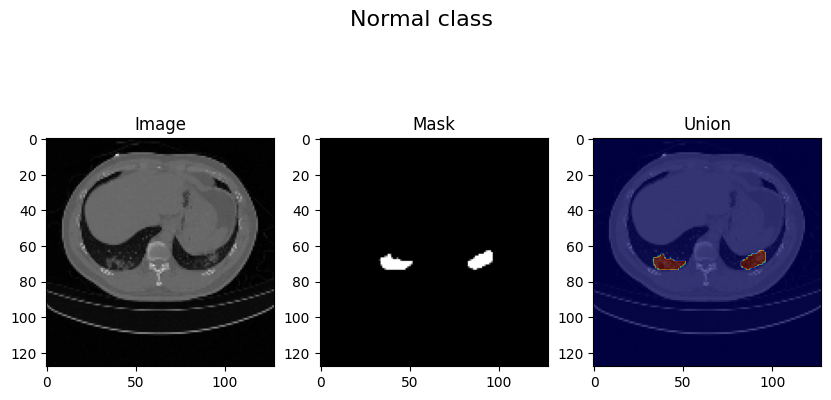

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(2048)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

### <span style="color:#2981d9;"> Prepare data to modeling </span>

In [ ]:
X = X[:2048]
y = y[:2048]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (2048, 128, 128)     |  y shape: (2048, 128, 128)

X shape: (2048, 128, 128, 1)  |  y shape: (2048, 128, 128, 1)


### <span style="color:#2981d9;"> Train-test split </span>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (1843, 128, 128, 1)
y_train shape: (1843, 128, 128, 1)
X_test shape: (205, 128, 128, 1)
y_test shape: (205, 128, 128, 1)


<a id="6.1"></a>
## <span style="color:#08bf2c;"> Building U-Net Architecture </span>

### <span style="color:#2981d9;"> Conv block </span>

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

### <span style="color:#2981d9;"> Encoder block </span>

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### <span style="color:#2981d9;"> Decoder block </span>

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

### <span style="color:#2981d9;"> Build model </span>

In [ ]:
size = 128
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

### <span style="color:#2981d9;"> Model plotting </span>

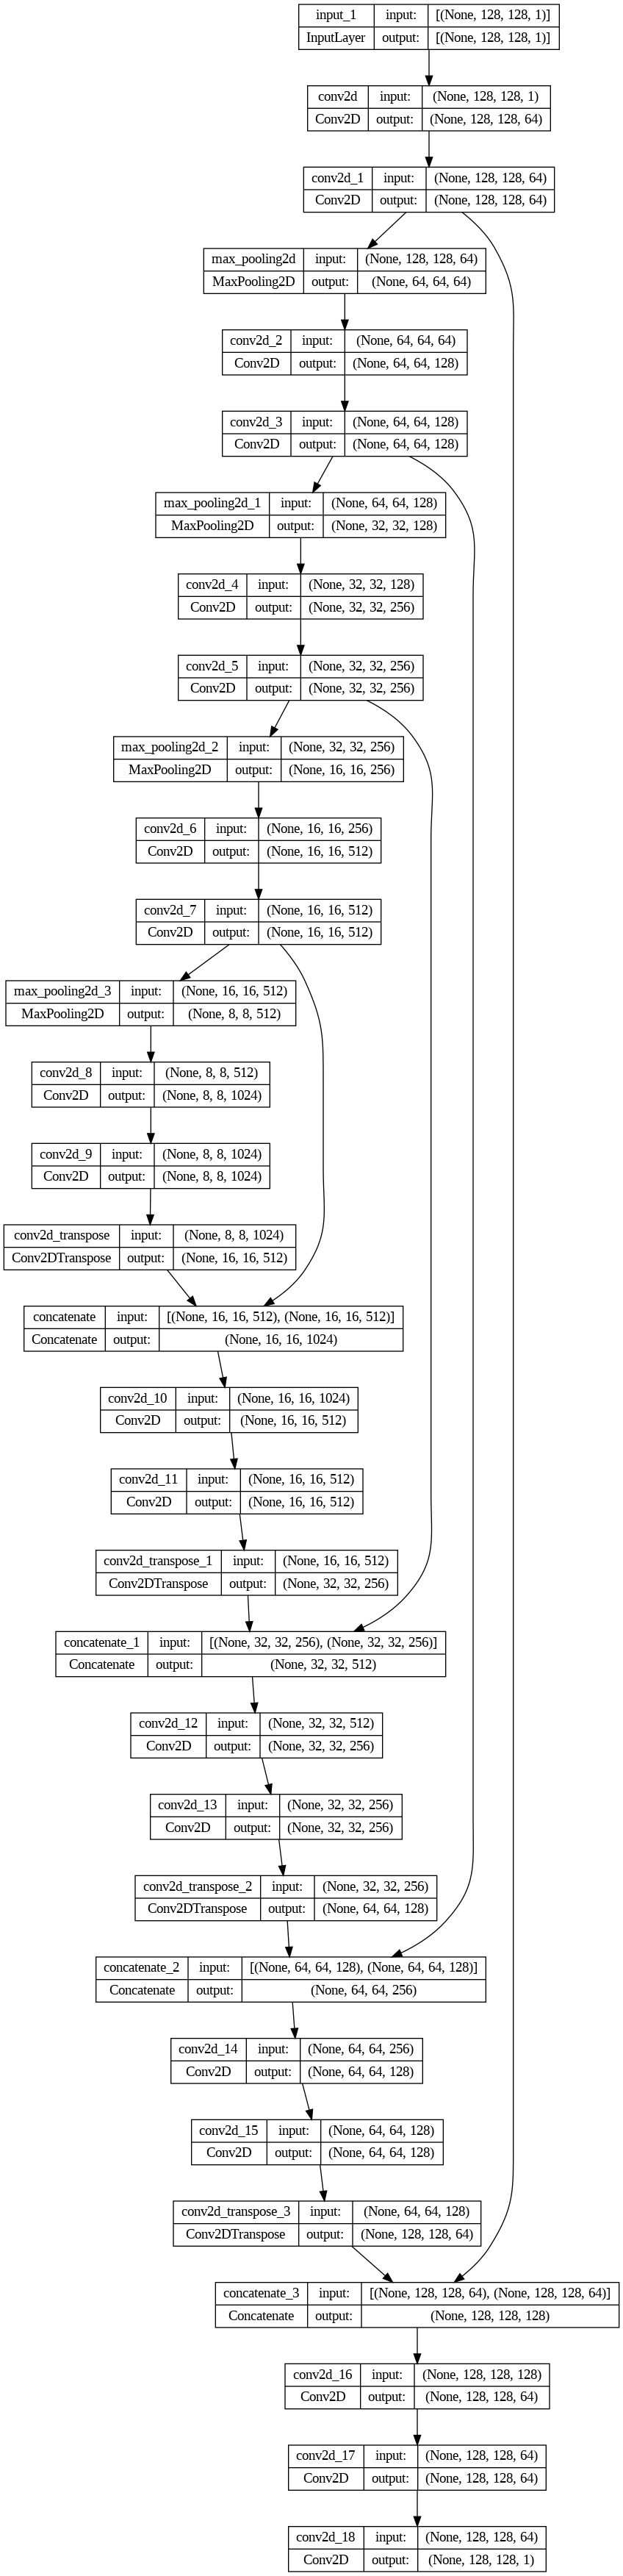

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### <span style="color:#2981d9;"> Model summary </span>

In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

<a id="6.2"></a>
## <span style="color:#08bf2c;"> Training </span>

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
58/58 [==============================] - 61s 542ms/step - loss: 0.2080 - accuracy: 0.9794 - val_loss: 0.0797 - val_accuracy: 0.9819
Epoch 2/100
58/58 [==============================] - 21s 358ms/step - loss: 0.0780 - accuracy: 0.9808 - val_loss: 0.0706 - val_accuracy: 0.9819
Epoch 3/100
58/58 [==============================] - 21s 354ms/step - loss: 0.0707 - accuracy: 0.9808 - val_loss: 0.0684 - val_accuracy: 0.9819
Epoch 4/100
58/58 [==============================] - 21s 366ms/step - loss: 0.0664 - accuracy: 0.9808 - val_loss: 0.0630 - val_accuracy: 0.9819
Epoch 5/100
58/58 [==============================] - 22s 375ms/step - loss: 0.0621 - accuracy: 0.9807 - val_loss: 0.0583 - val_accuracy: 0.9819
Epoch 6/100
58/58 [==============================] - 22s 376ms/step - loss: 0.0584 - accuracy: 0.9812 - val_loss: 0.0538 - val_accuracy: 0.9828
Epoch 7/100
58/58 [==============================] - 22s 373ms/step - loss: 0.0554 - accuracy: 0.9822 - val_loss: 0.0521 - val_accuracy:

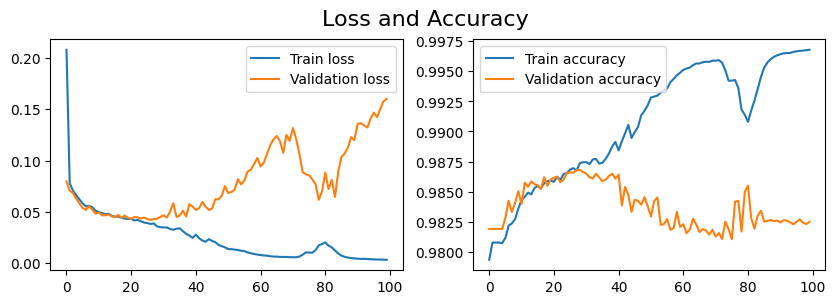

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()


# Evaluation

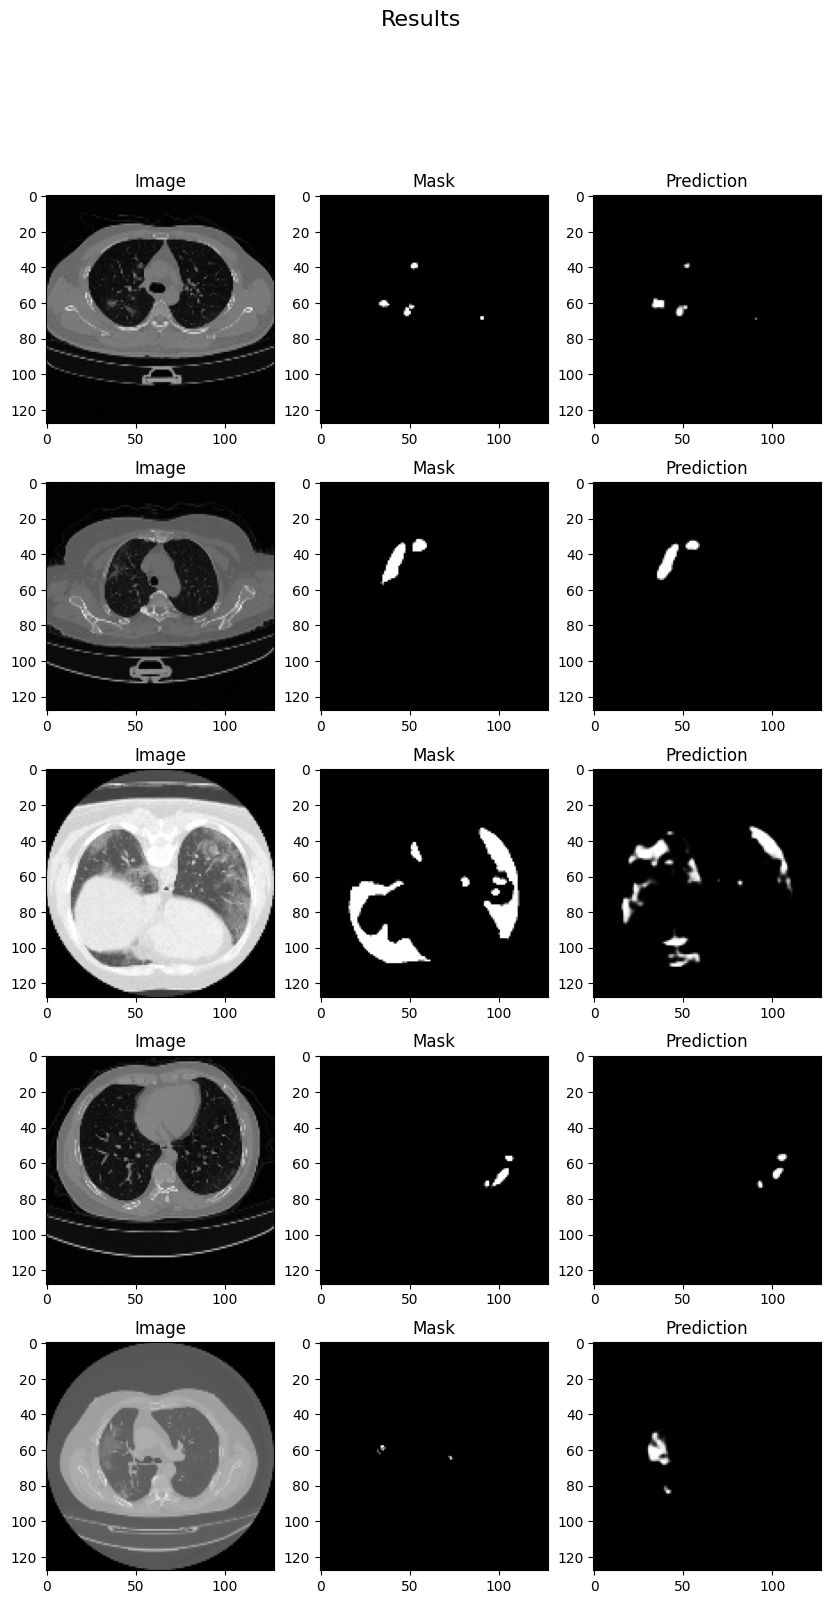

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.25

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Mean IoU = 0.66352075
Precision Score = 0.529
Recall Score = 0.502
F1 Score = 0.515
